In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dog Breed Identification using Transfer Learning

Objective is to fine tune a pretrained object classification model such as resnet/inception/vgg16 trained on large datasets and use their feature vector to build a fine-tuned model for specific purpose of dog-breed identification. 
Detailed description of problem staetment can be found on official page for competetion: https://www.kaggle.com/c/dog-breed-identification. 

### Description of training data
10222 images of Dogs, 120 classes.

### Procedure

1. Import a pre-trained network : Resnet V2 (101 layers) is imported using tensorflow hub.
2. Pre-process and augment input data for Resnet V2 ( 224x224x3 )
3. Extract feature embedding for each image using Resnet and build a ML model upon that for breed identification task.

## Importing Resnet from Tensorflow Hub

In [2]:
tf.logging.set_verbosity('ERROR')

# set trainable true/False -> fine tune entire model for input data
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1") #, trainable=True);
height, width = hub.get_expected_image_size(module);
shape = (height, width)

In [3]:
# tf.global_variables()
# module.variable_map
tf.logging.set_verbosity('INFO')
LOG_DIR = '.graphTransfer'
TRAIN_DIR = 'resTrain/'

## Preprocessing of Training Data for Resnet
 Traning images data have different aspect ratio and size. Images are reshaped to expected input size of resnet which is 244x244x3. All images are reshaped once and saved in a different directory, which is later used for all training purposes.
 
 To force resize images, delete the resized folder directory. 

In [4]:
# resize images in train folder if not in shape
def resize(shape=shape):
    
    originalFolder = 'train'
    resizedFolder  = 'resTrain'
    
    if not os.path.exists(resizedFolder):
        os.makedirs(resizedFolder)
        counter = 0
        # Iterate through resizing and saving
        for img in os.listdir('train'):
            counter = counter + 1
            pic = cv2.imread("train/" + img, cv2.IMREAD_UNCHANGED)
            pic = cv2.resize(pic, shape)
            cv2.imwrite(resizedFolder + '/' + img, pic)
            print("resized image : " + str(shape) + str(counter) + " : "+img + " : " );
    else:
        print("Rezied image already exists in folder:" + resizedFolder);
        return

# resize images to resnet accepted shape
resize(shape)

Rezied image already exists in folder:resTrain


## Iterator for Obtaining Batch
function tabkes input of batch size required and sequentially returns batches until entire training set is exhausted. Batch size can't be changed during training. 

In [5]:
label = pd.read_csv("labels.csv", delimiter=',', index_col=0) # 120 labels
labelOneHot = pd.get_dummies(label.breed) # 120 labels

# train and validation set
val_set = labelOneHot.sample(n=222, replace=False)
labelOneHot  = labelOneHot.drop(labels=val_set.index, axis=0)

global curr_batch  # flag to track current batch being fed in each epoch
curr_batch = 0     # first initialization, re-initialize with caution

'''
input batch-size, default = 100
uses global variable curr_batch to remember current batch location
returns tuple (flag for next batch, list of files, list of labels, 4-d array->(batch, h, w, c))
'''
def next_batch(batch_size=25, random=False):
    next_batch = True
    if random:
        label_list = val_set.sample(n=batch_size, replace=False)
        batch_list = label_list.index
    else:
        global curr_batch
        start = curr_batch*batch_size
        end   = (curr_batch+1)*batch_size
        # print("feeding Batch : " + str(curr_batch))
        # Check is it's last batch
        if ((curr_batch+1)*batch_size>len(labelOneHot)):
            end = len(labelOneHot)-1
            next_batch = False
        label_list = labelOneHot[start:end]
        batch_list = label_list.index

    
    batch = []
    for img in batch_list:
        pic = cv2.imread(TRAIN_DIR+img+".jpg", cv2.IMREAD_UNCHANGED)
        batch.append(pic)
    batch = np.stack(batch, axis=0)
    if not(random):
        curr_batch = curr_batch + 1
    
    return next_batch, batch_list, label_list, batch


## Image Transformation using Open CV 
to augment training data, random crop, blur, rotation, noising and skewing is performed on training data. Strength of each such transformations can be controlled using parameters in definition (parameters define maximum limit for transformation/distortion). However, transformations itself are random.

In [6]:
''' Image Transformation Definitions '''
'''
randomly crop image
set kee_dim true to keep input and out put dimensions same
cropped height and width fraction
'''
def random_crop(input, h_frac=0.6, w_frac=0.6, keep_dim=True):
    height, width, _ = input.shape
    h, w = int(h_frac*height), int(w_frac*width)
    y, x = np.random.randint(0, height-h), np.random.randint(0, width-w)
    if keep_dim:
        return cv2.resize(input[x:x+w, y:y+h, :], (height, width), interpolation=cv2.INTER_CUBIC)
    else:
        return input[x:x+w, y:y+h, :]

'''
Performs gaussian or median blur of random strength
upper limit of blur strength can be passes as parameter
'''
def random_blur(input, max_strength=0.2):
    h, w, _ = input.shape
    rand = np.random.randint(0, max_strength*h)
    if rand%2==0:
        max_strength = max_strength/4
        a, b = np.random.randint(1, int(max_strength*h)), np.random.randint(1, int(max_strength*w))
        a, b = 2*a+1, 2*b+1 
        return cv2.GaussianBlur(input,(a, b),0)
    else:
        rand = 2*int(rand/4)+1
        return cv2.medianBlur(input,rand)

'''
randomly rotate the image about center with scale factor of 1.1
'''
def random_rotate(input):
    rows, cols, _ = input.shape
    theta = np.random.randint(0, 360)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1.1)
    return cv2.warpAffine(input,M,(cols,rows))

def random_noise(input, strength=50):
    a, b, c = input.shape
    Strength = np.random.randint(0, strength)
    noise = np.random.randn(a, b, c)
    out = input+Strength*noise
    a = np.max(out); b = min(0, np.min(out))
    return np.uint8(254/(a-b)*(out-b))
     
def random_skew():

    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,200]])

    M = cv2.getAffineTransform(pts1,pts2)

    return cv2.warpAffine(img,M,(cols,rows))

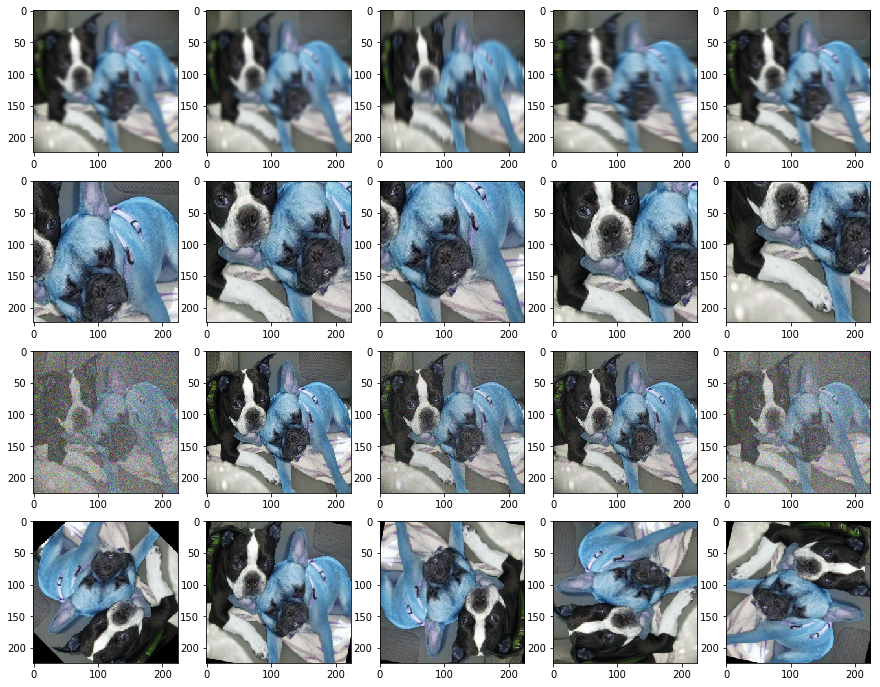

In [7]:
_, _, _, dog_img = next_batch(batch_size=1, random=True)

rand_transformation = [random_blur, random_crop, random_noise, random_rotate]

nrow = len(rand_transformation)
ncol = 5

fig, ax = plt.subplots(nrows=nrow, ncols=ncol)
fig.set_figwidth(15)
fig.set_figheight(12)

for i in range(nrow):
    for j in range(ncol):
        ax[i,j].imshow(rand_transformation[i](dog_img[0]), interpolation='nearest', aspect='auto')

In [8]:
rand_transformation = [random_blur, random_crop, random_noise, random_rotate]
num_trans = len(rand_transformation)
def imgaug(label, image):
    list_label = []
    list_image = []
    for lab,img in zip(label.values,image):
        list_label.append(lab)
        list_image.append(img)
        for i in range(num_trans):
            list_label.append(lab)
            list_image.append(rand_transformation[i](img))
    return list_label, np.stack(list_image, axis=0)

## Transfer learning using tensorflow

In [9]:
# Define retrain layer
with tf.name_scope("retrain_model"):
    # Input placeholders
    images = tf.placeholder(dtype=tf.float32, shape=(None, height, width, 3), name="input_images")
    y      = tf.placeholder(dtype=tf.int32, shape=(None, 120), name="labels")

    # bottleneck
    features = module(images)  # Features with shape [batch_size, 2048], last batch may differ in size
    # retraining model 
    dense1 = tf.layers.dense(inputs=features, units=1024, activation=tf.nn.relu, name="dense_1")
    logits = tf.layers.dense(inputs=dense1, units=120, name="dense_2")
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax")
    }
    xent = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y, logits=logits))

    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.01) \
                    .minimize(loss=xent, global_step=tf.train.get_global_step())

    eval_metric = {
        "accuracy": tf.metrics.accuracy(labels=y, predictions=predictions["probabilities"])}

    tf.summary.scalar('cross_entropy', xent)
    tf.summary.scalar('accuracy', eval_metric["accuracy"][0])

    # Set up logging for predictions
    tensors_to_log = {"probabilities":predictions["probabilities"], 
                      "accuracy": eval_metric["accuracy"], 
                      "train_cost": xent}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=1)

    summ = tf.summary.merge_all()

In [ ]:
batchNext = True
curr_batch = 0
counter = 0

with tf.Session() as sess:
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    saver  = tf.train.Saver()
    sess.run(init_g)
    sess.run(init_l)
    
    for epoch in range(2):
        curr_batch = 0
        while(batchNext):
            batchNext, _, batch_label, image = next_batch(20)  # A batch of images with shape [batch_size, height, width, 3].
            _, _, batch_label_cv, image_cv = next_batch(20, True) # randomly sample images for cross-validation [batch_size, height, width, 3].
          
            # apply image augmentation
            batch_label, image = imgaug(batch_label, image)
            batch_label_cv, image_cv = imgaug(batch_label_cv, image_cv)    
            
            [train_accuracy, s] = sess.run([eval_metric["accuracy"], summ], feed_dict={images: image, y: batch_label})
            [train_accuracy_cv, s_cv] = sess.run([eval_metric["accuracy"], summ], feed_dict={images: image_cv, y: batch_label_cv})
            writer.add_summary(s, counter)
            writer.add_summary(s_cv, counter)
            print("Epoch: %2d, Iteration: %3d, training accuracy : %6.5f , cv_accuracy: %6.5f"%(epoch, counter, train_accuracy[0], train_accuracy_cv[0]))
            if counter % 20 == 0:
                saver.save(sess, os.path.join(LOG_DIR, "kaggle-dog-identification.ckpt"), counter)
            sess.run(train_step, feed_dict={images: image, y: batch_label})
            counter = counter+1      


Epoch:  0, Iteration:   0, training accuracy : 0.00000 , cv_accuracy: 0.98342
Epoch:  0, Iteration:   1, training accuracy : 0.98354 , cv_accuracy: 0.98375
Epoch:  0, Iteration:   2, training accuracy : 0.98365 , cv_accuracy: 0.98358
Epoch:  0, Iteration:   3, training accuracy : 0.98354 , cv_accuracy: 0.98351
Epoch:  0, Iteration:   4, training accuracy : 0.98349 , cv_accuracy: 0.98347
Epoch:  0, Iteration:   5, training accuracy : 0.98346 , cv_accuracy: 0.98345
Epoch:  0, Iteration:   6, training accuracy : 0.98344 , cv_accuracy: 0.98343
Epoch:  0, Iteration:   7, training accuracy : 0.98348 , cv_accuracy: 0.98403
Epoch:  0, Iteration:   8, training accuracy : 0.98451 , cv_accuracy: 0.98493
Epoch:  0, Iteration:   9, training accuracy : 0.98530 , cv_accuracy: 0.98562
Epoch:  0, Iteration:  10, training accuracy : 0.98593 , cv_accuracy: 0.98620
Epoch:  0, Iteration:  11, training accuracy : 0.98645 , cv_accuracy: 0.98667
Epoch:  0, Iteration:  12, training accuracy : 0.98688 , cv_accu